<a href="https://colab.research.google.com/github/berkek55/DSA-210-Project/blob/main/DSAPenaltyKickProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [42]:
penalties_clean.to_pickle("/content/drive/MyDrive/penalties_clean.pkl")

In [10]:
import os
import json
import pandas as pd
from collections import defaultdict

events_dir = "/content/events/events"   # folder with all the match JSONs

penalty_events = []

file_list = [f for f in os.listdir(events_dir) if f.endswith(".json")]
print("Number of files:", len(file_list))

for i, filename in enumerate(file_list):
    file_path = os.path.join(events_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        match_events = json.load(f)  # list of events in this match

    # sort events by time so scoreline is correct
    match_events_sorted = sorted(
        match_events,
        key=lambda ev: (ev.get("minute", 0), ev.get("second", 0) or 0)
    )

    # track score in this match
    scores = defaultdict(int)   # team_name -> goals

    for ev in match_events_sorted:
        team = ev.get("team", {}).get("name")

        # identify shots
        if ev.get("type", {}).get("name") == "Shot":
            shot = ev.get("shot", {})

            # 1) if it's a PENALTY: record current score BEFORE the kick
            if shot.get("type", {}).get("name") == "Penalty":
                team_goals_before = scores[team]
                opp_goals_before = sum(scores.values()) - team_goals_before

                # attach score info to this event
                ev_copy = dict(ev)  # shallow copy is fine
                ev_copy["team_goals_before"] = team_goals_before
                ev_copy["opp_goals_before"] = opp_goals_before
                penalty_events.append(ev_copy)

            # 2) update score *after* we check for penalty
            outcome = shot.get("outcome", {}).get("name")
            if outcome == "Goal":
                scores[team] += 1

    if (i + 1) % 500 == 0:
        print(f"Processed {i+1} files, penalties so far: {len(penalty_events)}")

print("Total penalty events collected:", len(penalty_events))

# Now normalize ONLY penalties – small DF, no RAM issues
penalties = pd.json_normalize(penalty_events, sep="_")
print("Penalties DF shape:", penalties.shape)
penalties.head()

Number of files: 3464
Processed 500 files, penalties so far: 215
Processed 1000 files, penalties so far: 388
Processed 1500 files, penalties so far: 566
Processed 2000 files, penalties so far: 742
Processed 2500 files, penalties so far: 939
Processed 3000 files, penalties so far: 1130
Total penalty events collected: 1361
Penalties DF shape: (1361, 40)


,id,index,period,timestamp,minute,second,possession,location,duration,related_events,...,shot_outcome_id,shot_outcome_name,shot_technique_id,shot_technique_name,shot_one_on_one,shot_freeze_frame,shot_saved_to_post,out,off_camera,shot_follows_dribble
0,e8ef60ea-8ee5-4fda-a5c8-2b36250c6c3e,3142,2,00:29:23.694,74,23,125,"[108.1, 40.1]",0.458233,[ec55e567-35e6-4f61-9255-ba9c2b35ab18],...,97,Goal,93,Normal,NaN,NaN,NaN,NaN,NaN,NaN
1,1706936c-59d7-4a94-bb0d-fdfdba7ed1e3,3200,2,00:32:18.901,77,18,167,"[108.1, 40.1]",0.530800,[9aaa9490-8e95-4c57-b9c7-ce689e6c8f06],...,97,Goal,93,Normal,NaN,NaN,NaN,NaN,NaN,NaN
2,f894fea2-e84c-4b21-a7c6-a923d3992f41,2106,2,00:20:15.005,65,15,147,"[109.0, 41.0]",0.651000,[6f546e54-4eab-4703-85a4-cd7afa47e5ea],...,97,Goal,93,Normal,NaN,NaN,NaN,NaN,NaN,NaN
3,69c2f9c9-d363-4f5a-bd4e-941220862ec4,1901,2,00:23:33.112,68,33,153,"[109.0, 41.0]",0.411200,[dab8327a-69a5-4437-836c-264c436de7b7],...,100,Saved,93,Normal,NaN,NaN,NaN,NaN,NaN,NaN
4,293981df-86fe-4e2f-b9d0-e8560208dc9f,2275,2,00:15:33.068,60,33,110,"[108.2, 40.0]",0.327782,[85ae139f-577c-417a-803b-5a37497c0645],...,100,Saved,93,Normal,True,"[{'location': [119.3, 40.3], 'player': {'id': ...",NaN,NaN,NaN,NaN


In [18]:
penalties["score_diff"] = penalties["team_goals_before"] - penalties["opp_goals_before"]

In [19]:
columns_to_drop = [
    "off_camera",
    "out",
    "shot_saved_to_post",
    "shot_follows_dribble",
    "shot_one_on_one",
    "related_events",
    "position_name",
    "position_id",
    "play_pattern_id",
    "play_pattern_name",
    "duration",
    "possession_team_id",
    "possession_team_name",
    "type_id",
    "type_name",
    "index",
    "id",               # optional
    "possession",
    "location"          # optional
]
penalties_clean = penalties.drop(columns=[c for c in columns_to_drop if c in penalties.columns])

**ENGINEERED FEATURES**


**1-) SCORED (numeric target)**

In [20]:
penalties_clean["scored"] = (penalties["shot_outcome_name"] == "Goal").astype(int)

**2-) DIRECTION (LEFT/CENTER)**



In [21]:
import numpy as np

# Extract shot_end_location y-coordinates for goals only
goal_y = penalties_clean.loc[
    penalties_clean["shot_outcome_name"] == "Goal",
    "shot_end_location"
].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

goal_y.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,shot_end_location
count,998.000000
mean,39.876754
std,2.849956
min,35.900000
1%,36.200000
10%,36.600000
25%,37.000000
50%,39.500000
75%,43.000000
90%,43.400000


In [22]:
y_min = goal_y.min()
y_max = goal_y.max()

third = (y_max - y_min) / 3
left_end = y_min + third
center_end = y_min + 2*third

y_min, left_end, center_end, y_max

(35.9, 38.6, 41.3, 44.0)

In [23]:
import ast
import numpy as np

def classify_direction_thirds(loc):
    # Convert from string if needed
    if isinstance(loc, str):
        try:
            loc = ast.literal_eval(loc)
        except:
            return np.nan

    if not isinstance(loc, list) or len(loc) < 2:
        return np.nan

    y = loc[1]

    if y <= left_end:
        return "Left"
    elif y <= center_end:
        return "Centre"
    else:
        return "Right"

penalties_clean["direction"] = penalties_clean["shot_end_location"].apply(classify_direction_thirds)

**3-) PRESSURE METRIC (EXTREME/HIGH/MEDIUM/LOW)**

In [24]:
def classify_pressure(row):
    minute = row["minute"]
    diff = row["score_diff"]

    # 1) EXTREME: shootouts or very late close games
    if minute >= 120:
        return "Extreme"
    if minute >= 75 and diff in [0, -1]:
        return "Extreme"

    # 2) HIGH: second-half close games (but not already Extreme)
    if minute >= 45 and abs(diff) <= 1:
        return "High"

    # 3) MEDIUM: early close games OR late with 2-goal margin
    if abs(diff) <= 1:
        return "Medium"
    if minute >= 60 and abs(diff) == 2:
        return "Medium"

    # 4) LOW: big margins & early-ish game
    return "Low"

penalties_clean["pressure"] = penalties_clean.apply(classify_pressure, axis=1)

In [25]:
penalties_clean.head(20)

,period,timestamp,minute,second,team_goals_before,opp_goals_before,team_id,team_name,player_id,player_name,...,shot_type_name,shot_outcome_id,shot_outcome_name,shot_technique_id,shot_technique_name,shot_freeze_frame,score_diff,scored,direction,pressure
0,2,00:29:23.694,74,23,3,1,217,Barcelona,5246,Luis Alberto Suárez Díaz,...,Penalty,97,Goal,93,Normal,NaN,2,1,Left,Medium
1,2,00:32:18.901,77,18,1,3,222,Villarreal,26192,Matías Ariel Fernández Fernández,...,Penalty,97,Goal,93,Normal,NaN,-2,1,Left,Medium
2,2,00:20:15.005,65,15,0,2,974,Reading WFC,10251,Fara Williams,...,Penalty,97,Goal,93,Normal,NaN,-2,1,Right,Medium
3,2,00:23:33.112,68,33,0,2,970,Yeovil Town LFC,15715,Ellie Mason,...,Penalty,100,Saved,93,Normal,NaN,-2,0,Right,Medium
4,2,00:15:33.068,60,33,0,4,218,Real Betis,6832,Rubén Castro Martín,...,Penalty,100,Saved,93,Normal,"[{'location': [119.3, 40.3], 'player': {'id': ...",-4,0,Right,Low
5,2,00:47:05.262,92,5,6,2,217,Barcelona,5246,Luis Alberto Suárez Díaz,...,Penalty,97,Goal,93,Normal,NaN,4,1,Right,Low
6,5,00:00:07.280,120,7,0,0,788,Morocco,3634,Abdelhamid Sabiri,...,Penalty,97,Goal,93,Normal,NaN,0,1,Right,Extreme
7,5,00:01:00.188,121,0,0,1,772,Spain,6720,Pablo Sarabia García,...,Penalty,99,Post,93,Normal,"[{'location': [119.5, 40.3], 'player': {'id': ...",-1,0,Right,Extreme
8,5,00:01:51.058,121,51,1,0,788,Morocco,5237,Hakim Ziyech,...,Penalty,97,Goal,93,Normal,NaN,1,1,Centre,Extreme
9,5,00:02:44.048,122,44,0,2,772,Spain,6583,Carlos Soler Barragán,...,Penalty,100,Saved,93,Normal,NaN,-2,0,Right,Extreme


**EXPLORATORY DATA ANALYSIS (EDA)**

**1-)PENALTY OUTCOMES**

shot_outcome_name
Goal             998
Saved            253
Off T             55
Post              44
Saved to Post      9
Wayward            2
Name: count, dtype: int64

scored
1    998
0    363
Name: count, dtype: int64

Goal rate:  0.7332843497428362


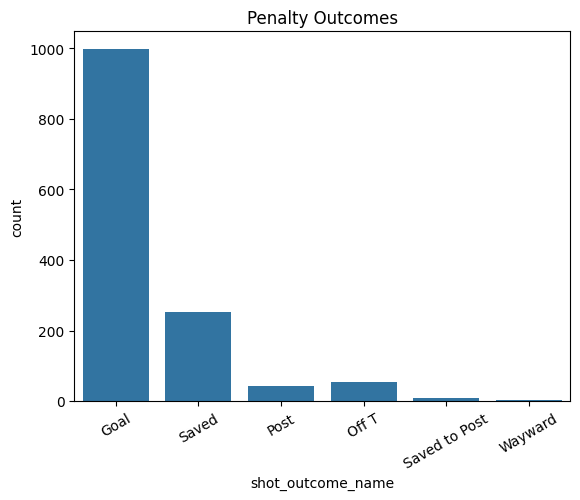

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count of outcomes
print(penalties_clean["shot_outcome_name"].value_counts())
print()

# Goal vs non-goal using the binary column
print(penalties_clean["scored"].value_counts())

# Percentage
print("\nGoal rate: ", penalties_clean["scored"].mean())

#Plot
sns.countplot(data=penalties_clean, x="shot_outcome_name")
plt.title("Penalty Outcomes")
plt.xticks(rotation=30)
plt.show()

**2-)PENALTY DIRECTIONS**

Direction counts:
direction
Left      647
Right     561
Centre    153
Name: count, dtype: int64

Direction percentages:
direction
Left      47.538575
Right     41.219691
Centre    11.241734
Name: proportion, dtype: float64


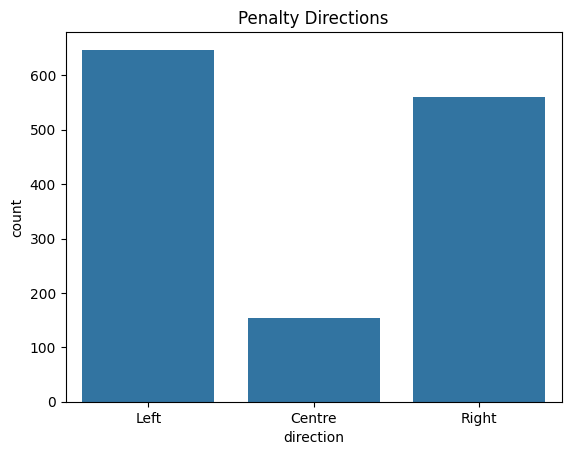

direction
Centre    0.758170
Left      0.717156
Right     0.745098
Name: scored, dtype: float64


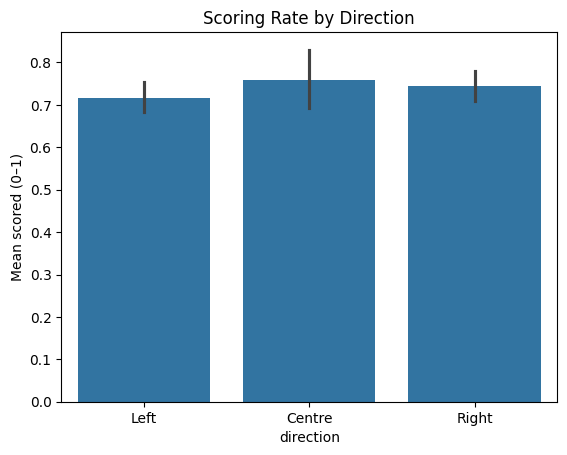

In [27]:
#Counts and percentages

print("Direction counts:")
print(penalties_clean["direction"].value_counts())
print("\nDirection percentages:")
print(penalties_clean["direction"].value_counts(normalize=True) * 100)

#Plot

sns.countplot(data=penalties_clean, x="direction",
              order=["Left", "Centre", "Right"])
plt.title("Penalty Directions")
plt.show()

#Success rate by direction
dir_success = penalties_clean.groupby("direction")["scored"].mean().sort_index()
print(dir_success)

#Plot

sns.barplot(
    data=penalties_clean,
    x="direction",
    y="scored",
    order=["Left", "Centre", "Right"]
)
plt.title("Scoring Rate by Direction")
plt.ylabel("Mean scored (0–1)")
plt.show()


**3-) PENALTY PRESSURE**

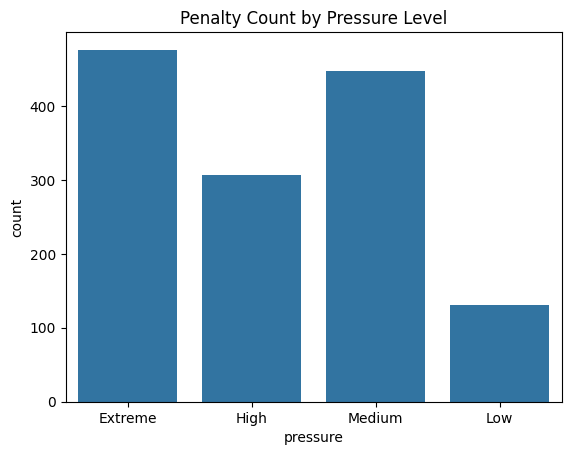

In [33]:
order_pressure = ["Extreme", "High", "Medium", "Low"]

sns.countplot(
    data=penalties_clean,
    x="pressure",
    order=order_pressure
)
plt.title("Penalty Count by Pressure Level")
plt.show()

pressure
Extreme    0.686975
High       0.758958
Medium     0.753915
Low        0.770992
Name: scored, dtype: float64


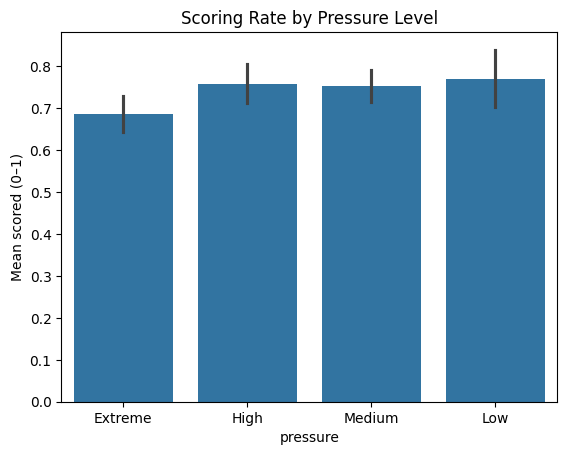

In [34]:
press_success = penalties_clean.groupby("pressure")["scored"].mean().reindex(order_pressure)
print(press_success)

sns.barplot(
    data=penalties_clean,
    x="pressure",
    y="scored",
    order=order_pressure
)
plt.title("Scoring Rate by Pressure Level")
plt.ylabel("Mean scored (0–1)")
plt.show()

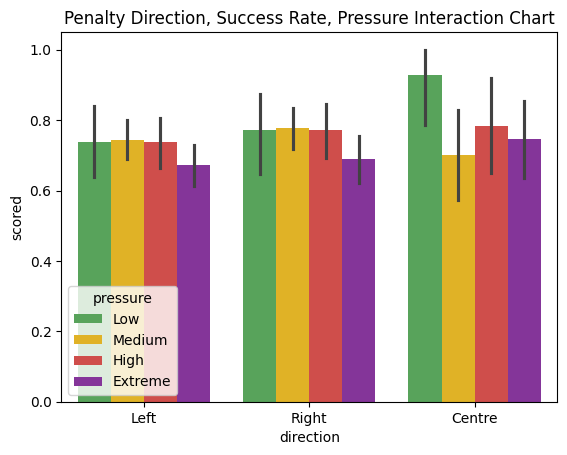

In [43]:
order = ["Low", "Medium", "High", "Extreme"]

palette = {
    "Low": "#4CAF50",
    "Medium": "#FFC107",
    "High": "#E53935",
    "Extreme": "#8E24AA"
}

sns.barplot(
    data=penalties_clean,
    x="direction",
    y="scored",
    hue="pressure",
    order=["Left", "Right", "Centre"],
    hue_order=order,
    palette=palette
)
plt.title("Penalty Direction, Success Rate, Pressure Interaction Chart")
plt.show()

**HYPOTHESIS TESTING**


**Hypothesis Test 1: Pressure affects penalty success (CHI-SQUARE)**

H0: Pressure level has no effect on penalty success.

H1: Pressure level does affect penalty success.

In [44]:
from scipy.stats import chi2_contingency
import pandas as pd

# Contingency table
ct1 = pd.crosstab(penalties_clean["pressure"], penalties_clean["scored"])
print("Contingency Table:")
print(ct1)

# Chi-square test
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(ct1)

print("\nChi-square statistic:", chi2_1)
print("Degrees of freedom:", dof_1)
print("p-value:", p_1)

Contingency Table:
scored      0    1
pressure          
Extreme   149  327
High       74  233
Low        30  101
Medium    110  337

Chi-square statistic: 8.179272088412738
Degrees of freedom: 3
p-value: 0.042448406370879516


**CONCLUSION:**
My significance level for this test was alpha= 0.05. After doing the chi-square test, it shows a significant relationship between pressure and penalty success as our p-value is 0.042, which is smaller than the significance level. Therefore we can reject the null hypothesis and conclude that pressure significantly affects penalty success. Players under Extreme and High pressure showed lower success rates compared to those under Low or Medium pressure, supporting the psychological expectation that increased pressure negatively impacts performance.

**Hypothesis Test 2: Pressure affects penalty direction (CHI-SQUARE)**

H0: Pressure does not affect where players shoot (Left, Centre, Right).

H1: Pressure does affect direction choice.

In [45]:
# Pressure vs Direction
ct2 = pd.crosstab(penalties_clean["pressure"], penalties_clean["direction"])
print("Contingency Table:")
print(ct2)

chi2_2, p_2, dof_2, expected_2 = chi2_contingency(ct2)

print("\nChi-square statistic:", chi2_2)
print("Degrees of freedom:", dof_2)
print("p-value:", p_2)

Contingency Table:
direction  Centre  Left  Right
pressure                      
Extreme        55   225    196
High           37   134    136
Low            14    69     48
Medium         47   219    181

Chi-square statistic: 3.8070376205904624
Degrees of freedom: 6
p-value: 0.7027702885612288


**CONCLUSION:**
Our p-value 0.70 is much higher than the significance level of 0.05, so we fail to reject the null hypothesis. This means the chi-square test finds no meaningful relationship between pressure level and the direction players choose when taking a penalty.

Even though pressure clearly affects whether a penalty is scored, it does not appear to change where players aim. The data suggests that players stick to their usual shooting preferences—Left, Centre, or Right—regardless of whether the situation is Low, Medium, High, or Extreme pressure.

**Hypothesis Test 3: Pressure affects miss type(CHI-SQUARE) type**

H0: Pressure level does not affect miss type.

H1: Pressure level does have an effect on miss type.

In [47]:
misses["shot_outcome_name"].value_counts()

,count
shot_outcome_name,
Saved,253
Off T,55
Post,44
Saved to Post,9
Wayward,2


In [48]:
misses = penalties_clean[penalties_clean["scored"] == 0].copy()

# Merging categories
misses["miss_group"] = misses["shot_outcome_name"].replace({
    "Saved to Post": "Saved",
    "Saved": "Saved",
    "Wayward": "Off Target",
    "Off T": "Off Target",
    "Post": "Post"
})

In [49]:
misses["miss_group"].value_counts()

,count
miss_group,
Saved,262
Off Target,57
Post,44


Some of the miss types in my dataset had very few samples. For example, Wayward only showed up twice and Saved to Post appeared 9 times.
When categories are this small, the chi-square test becomes unreliable because it expects each group to have a reasonable number of observations.

To fix this, I combined similar outcomes into more meaningful groups:
	•	I merged “Saved” and “Saved to Post” because both involve the goalkeeper getting a touch on the shot.
	•	I merged “Off T” and “Wayward” since both are basically off-target mistakes by the player.
	•	I kept “Post” as its own category because hitting the post is a different type of miss compared to shooting wide or being saved.

This way, the categories make more football sense and the chi-square test becomes valid again.


In [50]:
from scipy.stats import chi2_contingency
import pandas as pd

# Contingency table
ct3 = pd.crosstab(misses["pressure"], misses["miss_group"])
print("Contingency Table:")
print(ct3)

# Chi-square test
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(ct3)

print("\nChi-square statistic:", chi2_3)
print("Degrees of freedom:", dof_3)
print("p-value:", p_3)

Contingency Table:
miss_group  Off Target  Post  Saved
pressure                           
Extreme             24    25    100
High                12    11     51
Low                  4     1     25
Medium              17     7     86

Chi-square statistic: 9.889974036191552
Degrees of freedom: 6
p-value: 0.12936257674729368


**CONCLUSION:**
The chi-square test returned a p-value of 0.129, which is clearly higher than the 0.05 significance level. Because of this, we fail to reject the null hypothesis. In simple terms, pressure does not appear to change how players miss penalties.

Even though pressure affects whether the penalty is scored, as shown in the first test, the distribution of miss types, whether the shot is saved, goes off-target, or hits the post, stays roughly the same across Low, Medium, High, and Extreme pressure situations. Players under pressure don’t seem to switch to a different kind of mistake; they just miss slightly more often overall.

This suggests that pressure influences success, but it does not strongly influence the nature of the miss. The type of failure seems to be more about the player’s technique and habits rather than the pressure of the moment.


**HYPOTHESIS TESTING SUMMARY**

After running all three hypothesis tests, a pretty clear picture started to form.
The main thing I found is that pressure does affect whether a penalty is scored, but it doesn’t really change the player’s decisions or the specific way the penalty is missed.

In the first test, I checked if pressure levels change the success rate. The result was actually significant. The p-value (0.042) was below 0.05, which means players really do struggle more in tougher situations like late-game moments or shootouts. So pressure clearly matters for the final outcome.

In the second test, I looked at whether pressure affects where players shoot (Left, Centre, Right), the p-value was very high (0.70). This basically tells us that players don’t suddenly change their direction choice just because the situation is stressful. They stick to their usual habits, even under pressure.

The third test checked if pressure changes how players miss (saved, off target, or hitting the post). Again, the result wasn’t significant (p = 0.129). This means that even though players miss more often in high pressure, the type of miss doesn’t change much. They don’t suddenly start hitting the post more or sending shots into the stands just because of pressure. They just fail slightly more often overall.

Taken together, these results paint a clear and realistic picture:
penalty takers seem to maintain their usual shooting decisions regardless of pressure, but the increased stress still lowers their overall success rate. Pressure influences execution, not strategy, which is consistent with how professional footballers typically behave in high-stakes moments.